In [1]:
%%capture
import numpy as np
import pandas as pd
#import geopandas as gpd
import json
import matplotlib.pyplot as plt

from shapely import wkt
import os


import rasterio as rio
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from rasterio.mask import mask
import geopandas as gpd
import rioxarray as rxr
import pickle

from google.colab import drive
drive.mount('/content/drive')

In [53]:
%%capture
!pip install pytorch_lightning
import torch

In [24]:
%%capture
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas-1.5.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4


In [113]:
data_dir = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets"

In [335]:
DMG_CLASSES_DICT = {'no-damage': 0,
                    'minor-damage': 1,
                    'major-damage': 2,
                    'destroyed': 3,
                    'un-classified': 4}

In [82]:
def prediction_to_class(x):
  input_max, max_classification = torch.max(x, 1)
  damage_class = int(max_classification.numpy()[0])
  return damage_class

In [ ]:
def path_to_image(x):
  if "hold" in x:
    folder = "hold"
  if "tier1" in x:
    folder = "tier1"
  if "tier3" in x:
    folder = "tier3"
  if "test" in x:
    folder = "test"
  data_dir = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets"
  path = os.path.join(data_dir, "xBD_data/geotiffs", folder, "images")
  return path

In [136]:
def pickle_to_test(data_dir, path):
  df_path = os.path.join(data_dir, "checkpoints/test_datasets/test_df_balanced_70-20-10.pkl")
  df = pd.read_pickle(df_path)
  model_index = list(range(len(df)))
  df["model_index"] = np.array(model_index)
  df = df[["id", "polygony", "pointy", "damage_class", "model_index", "json_link", "image_name"]]
  return df

In [344]:
def pickle_to_merged(data_dir, pickle_path, test_df):
  df_path = os.path.join(data_dir, pickle_path)
  df = pd.read_pickle(df_path)
  df = pd.DataFrame(df, columns = ["pred_1x_balanced_14f_all", "images_only"])
  model_index = list(range(len(df)))
  df["model_index"] = np.array(model_index)
  df["class_prediction"] = df["pred_1x_balanced_14f_all"].apply(prediction_to_class)
  dict2 = {v : k for k, v in DMG_CLASSES_DICT.items()}
  df["damage_pred_categorical"] = df["class_prediction"].replace(dict2)
  df = pd.merge(df, test_df, on="model_index", how="left")
  df["damage_test_categorical"] = df["damage_class"].replace(dict2)
  df = df.rename(columns ={"polygony":"geometry"})
  gdf = gpd.GeoDataFrame(
    df, geometry=df["geometry"].apply(wkt.loads))
  
  df["image_path"] = df["json_link"].apply(path_to_image)
  return gdf

In [338]:
testdf_1x_balanced_14f = pickle_to_test(data_dir, "checkpoints/test_datasets/test_df_balanced_70-20-10.pkl")

In [345]:
merged_df_resnet_1x_balanced_14f = pickle_to_merged(data_dir, "checkpoints/experiment_resnet_1x_balanced_14f/predictions_list_resnet.pickle", testdf_1x_balanced_14f)
merged_df_swin_1x_balanced_14f = pickle_to_merged(data_dir, "checkpoints/experiment_swin_1x_balanced_14f/prediction_list_swin.pkl", testdf_1x_balanced_14f)

## Plot predictions for resnet, zoom 1x, 14 features, balanced dataset

In [342]:
from sklearn.metrics import accuracy_score
def test_accuracy(df):
  y_test = df["damage_class"].tolist()
  y_pred = df["class_prediction"].tolist()
  print(accuracy_score(y_test, y_pred))

In [346]:
test_accuracy(merged_df_resnet_1x_balanced_14f)

0.6223591549295775


In [352]:
id = 0
for i in unique_images:
  image_df = df[df["image_name"] == i]
  if len(image_df) > 12:
    print(id)
  id += 1

150
152
433
664
668


In [349]:
def plot_polygons(unique_image_name, data_dir, df, damage_plot):
  image_df = df[df["image_name"] == unique_image_name] 
  image_path = image_df["image_path"].iloc[0]
  specific_path = os.path.join(image_path, unique_image_name.replace("png", "tif"))

  with rio.open(specific_path) as img:
    fig, ax = plt.subplots(figsize=(8, 8))
    rio.plot.show(img.read(), ax=ax)
    if damage_plot == "test":
      image_df.plot(ax=ax, column = "damage_test_categorical", cmap = plt.get_cmap('RdYlBu'), legend=True)
      fig.suptitle("Damage ground truth polygons", fontsize=18)
    else:
      image_df.plot(ax=ax, column = "damage_pred_categorical", cmap = plt.get_cmap('RdYlBu'), legend=True)
      fig.suptitle("Damage predicted polygons", fontsize=18)

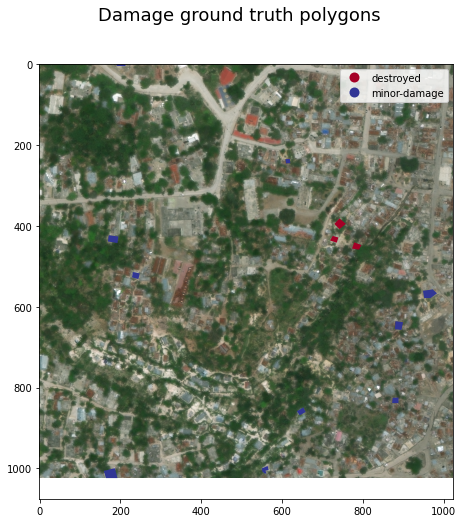

In [353]:
unique_images = list(set(merged_df_resnet_1x_balanced_14f["image_name"]))
plot_polygons(unique_images[152], data_dir, merged_df_resnet_1x_balanced_14f, "test")

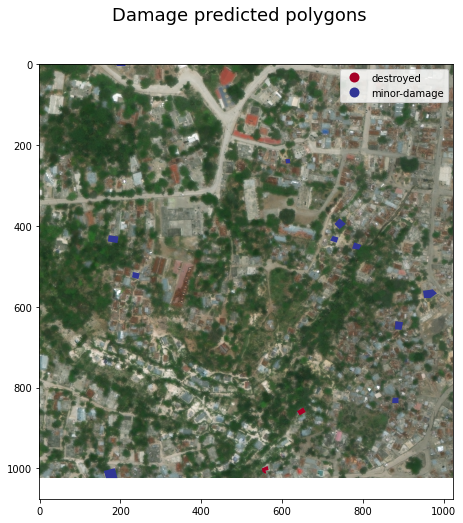

In [355]:
unique_images = list(set(merged_df_resnet_1x_balanced_14f["image_name"]))
plot_polygons(unique_images[152], data_dir, merged_df_resnet_1x_balanced_14f, "predicted")

## Plot predictions for swin, zoom 1x, 14 features, balanced dataset

In [130]:
test_accuracy(merged_df_swin_1x_balanced_14f)

0.6263204225352113


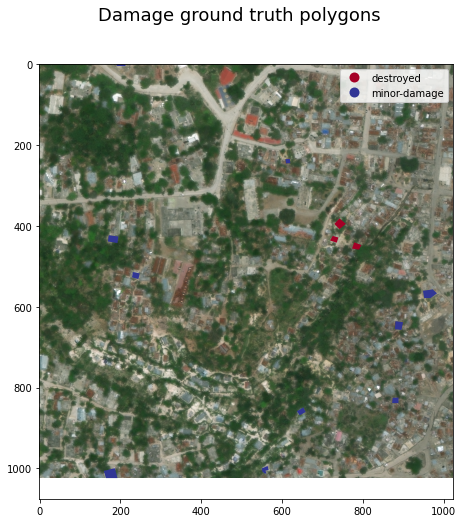

In [356]:
unique_images = list(set(merged_df_swin_1x_balanced_14f["image_name"]))
plot_polygons(unique_images[152], data_dir, merged_df_swin_1x_balanced_14f, "test")